<a href="https://colab.research.google.com/github/jkoniecznyy/Machine-learning/blob/main/Nerual_Networks_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importy

In [ ]:
import os
import glob
import time

import numpy as np
import tensorflow

import matplotlib.pyplot as plt
from google.colab import drive

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input as efficientnet_preprocess_input

In [ ]:
!python --version
print(np.__version__)
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

Python 3.10.12
1.22.4
2.12.0
2.12.0


In [ ]:
drive.mount('/content/drive')
configuration_time_start = time.time()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ustawienia

In [ ]:
#Ogólne
LR = 0.001 #0.002
BATCH_SIZE = 32 #64
EPOCHS = 2
DAY="08_03"
DATA_PATH = ""
DATASET_NAME = ""

#Modele
MODELS_INFO = [
    ("Xception", Xception(weights='imagenet', include_top=False), xception_preprocess_input, 299),
    ("Mobilenet", MobileNetV2(weights='imagenet', include_top=False), mobilenet_preprocess_input, 224),
    ("DenseNet169", DenseNet169(weights='imagenet', include_top=False), densenet_preprocess_input, 224),
    ("EfficientNetV2B0", EfficientNetV2B0(weights='imagenet', include_top=False), efficientnet_preprocess_input, 224)
]

#Datasety
DIRECTORIES = ['train', 'test', 'valid']
DATASETS_INFO = [
    ("IntelMini", "/content/drive/MyDrive/Mgr/TLDataMINI/"),
    ("Sport", "/content/drive/MyDrive/Mgr/Sport/"),
    ("Intel", "/content/drive/MyDrive/Mgr/TLData/")
]

In [ ]:
def count_files(directory_path):
    count = 0
    for _, _, files in os.walk(directory_path):
        count += len(files)
    return count

In [ ]:
!nvidia-smi

Thu Aug  3 16:49:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |    897MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Konfiguracja


In [ ]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Arguments:
        base_model: keras model (without a top layer)
        nb_classes: number of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    # Add the last layer and ((optionally) a dense layer
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model



def setup_to_transfer_learn(model, args):
    """Freezes all layers but the last one and compiles the model"""

    # TODO: Set all the layers but last one to not trainable.
    # Note: If you added more than one layer in the add_new_last_layer
    # function you should set all these layers to trainable.
    for layer in model.layers[:-1]:
      layer.trainable=False
    model.layers[-1].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def setup_to_finetune(model, args, not_trainable):
    """Freezes the first not_trainable layers, and unfreezes the rest
    Arguments:
        model: keras model
        not_trainable: number of not trainable layers
    """

    #Set the layers [0:not_trainable] to not trainable. Set the layers [not_trainable:] to trainable
    for i in range(not_trainable):
      model.layers[i].trainable=False

    for i in range(not_trainable, len(model.layers)):
      model.layers[i].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def trainable_params(model, output_format = 'en_US'):
    """Computes the number of trainable parameters in the model.
    Args:
        model: keras model
        output_format: (default: 'en_US')
            'int'   - number of trainable parameters (12345)
            'en_US' - number of trainable parameters formated to comma separated str ('12,235')
    """

    def nr_to_string(number, separator = ','):
        """
        Changes numbers to string.
        """
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    # And the real trainable_params function

    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret

In [ ]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history, save_path):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1

    fig = plt.figure(figsize=(12, 4))
    # fig.set_title(f'{NETWORK_NAME}_{DAY}')

    ax1 = fig.add_subplot(121)
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)

    ax2 = fig.add_subplot(122)
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    #ax2.legend(loc='upper left');
    ax2.grid(True)
    fig.savefig(save_path)
    plt.show()


def process_and_display(history, old_history, save_path):
    new_history = unpack_history(history, old_history)
    plot_history(new_history, save_path)
    return new_history

In [ ]:
class Args():
    def __init__(self, size):

        self.im_width, self.im_height = size, size
        self.lr = LR
        self.batch_size = BATCH_SIZE

        local_folder = DATA_PATH
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')

## Trening

In [ ]:
def transfer_learn():
  for model_name, model, preprocess_input_func, size in MODELS_INFO:
    FIGURE_SAVE_PATH = f"/content/drive/MyDrive/Mgr/new_plots/{DATASET_NAME}_{model_name}_{DAY}"
    WEIGHTS_SAVE_PATH = f"/content/drive/MyDrive/Mgr/new_wages/{DATASET_NAME}_{model_name}_{DAY}"
    args = Args(size)
    print(size)
    print(args.im_width, args.im_height)
    nb_train_samples = get_nb_files(args.train_dir)
    classes = glob.glob(args.train_dir + "/*")
    classes = [x.split('/')[-1] for x in classes]
    classes.sort()
    nb_classes = len(classes)
    nb_valid_samples = get_nb_files(args.valid_dir)


    for dir in DIRECTORIES:
      directory_path = f"{DATA_PATH}{dir}/"
      print(f'{dir}: {count_files(directory_path)}')
      for clas in classes:
        directory_path = f"{DATA_PATH}{dir}/{clas}/"
        print(f'    {clas}: {count_files(directory_path)}')

    train_steps = int (nb_train_samples / args.batch_size)
    valid_steps = int (nb_valid_samples / args.batch_size)
    print ('Train dataset contains {} samples ({} steps / epoch)'.format(nb_train_samples, train_steps))
    print ('Valid dataset contains {} samples ({} steps / epoch)'.format(nb_valid_samples, valid_steps))
    print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))

    train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input_func,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
    )

    train_generator = train_datagen.flow_from_directory(
        args.train_dir,
        target_size=(args.im_width, args.im_height),
        batch_size=args.batch_size,
    )

    validation_generator = test_datagen.flow_from_directory(
        args.valid_dir,
        target_size=(args.im_width, args.im_height),
        batch_size=args.batch_size,
    )

    test_generator = test_datagen.flow_from_directory(
        args.test_dir,
        target_size=(args.im_width, args.im_height),
        batch_size=args.batch_size
    )
    model = add_new_last_layer(model, nb_classes)
    setup_to_transfer_learn(model, args)

    configuration_time_end = time.time()
    tf_time_start = time.time()

    history = model.fit(
        train_generator,
        steps_per_epoch = train_steps,
        epochs = EPOCHS,
        validation_data=validation_generator,
        validation_steps = valid_steps,
    )
    tf_time_end = time.time()
    t1 = (configuration_time_end - configuration_time_start)  / 60
    t2 = (tf_time_end - tf_time_start) / 60
    print(f"Transfer learning: {t2:.2f} minutes")

    tl_history = process_and_display(history, None, f'{FIGURE_SAVE_PATH}')
    model.save(f'{WEIGHTS_SAVE_PATH}')
    nb_test_samples = get_nb_files(args.test_dir)
    test_steps = int (nb_test_samples / args.batch_size)
    model.evaluate(test_generator, steps=test_steps)
    # Format the outputs
    # output = f"Config: {t1:.2f} minutes\n"
    output = f"Transfer learning: {t2:.2f} minutes\n"
    # output += f"all: {t6:.2f} minutes"

    print(output)
    file_path = f"{FIGURE_SAVE_PATH}time.txt"
    with open(file_path, 'w') as file:
        file.write(output)
    print("Output saved to the file:", file_path)


299
299 299
train: 914
    buildings: 130
    forest: 136
    glacier: 117
    mountain: 219
    sea: 156
    street: 156
test: 244
    buildings: 64
    forest: 10
    glacier: 70
    mountain: 100
    sea: 0
    street: 0
valid: 1090
    buildings: 200
    forest: 200
    glacier: 110
    mountain: 180
    sea: 200
    street: 200
Train dataset contains 914 samples (28 steps / epoch)
Valid dataset contains 1090 samples (34 steps / epoch)
Dataset contains 6 classes (['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']).
Found 914 images belonging to 6 classes.
Found 1090 images belonging to 6 classes.
Found 244 images belonging to 6 classes.
Epoch 1/2
28/28 [==============================] - 815s 29s/step - loss: 1.3394 - accuracy: 0.5907 - val_loss: 0.9243 - val_accuracy: 0.7767
Epoch 2/2
28/28 [==============================] - 33s 1s/step - loss: 0.7497 - accuracy: 0.8050 - val_loss: 0.5933 - val_accuracy: 0.8336
Transfer learning: 14.36 minutes


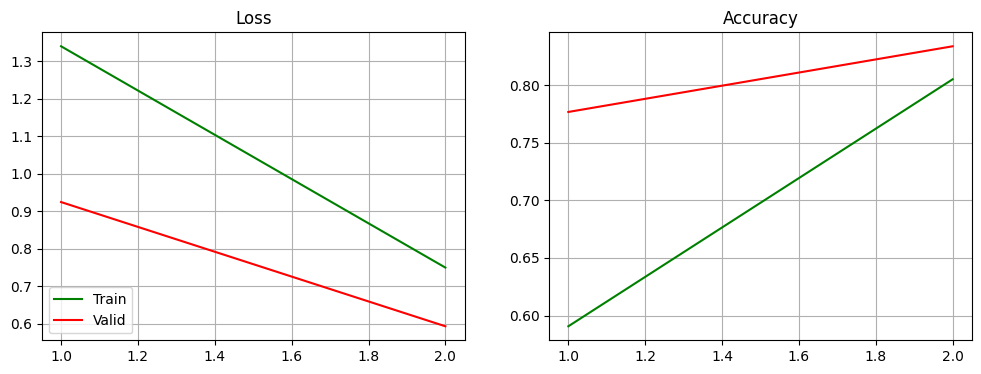

7/7 [==============================] - 55s 9s/step - loss: 0.7394 - accuracy: 0.7009
Transfer learning: 14.36 minutes

Output saved to the file: /content/drive/MyDrive/Mgr/new_plots/IntelMini_Xception_08_03time.txt
224
224 224
train: 914
    buildings: 130
    forest: 136
    glacier: 117
    mountain: 219
    sea: 156
    street: 156
test: 244
    buildings: 64
    forest: 10
    glacier: 70
    mountain: 100
    sea: 0
    street: 0
valid: 1090
    buildings: 200
    forest: 200
    glacier: 110
    mountain: 180
    sea: 200
    street: 200
Train dataset contains 914 samples (28 steps / epoch)
Valid dataset contains 1090 samples (34 steps / epoch)
Dataset contains 6 classes (['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']).
Found 914 images belonging to 6 classes.
Found 1090 images belonging to 6 classes.
Found 244 images belonging to 6 classes.
Epoch 1/2
28/28 [==============================] - 22s 659ms/step - loss: 1.4519 - accuracy: 0.4365 - val_loss: 0.7644 - va

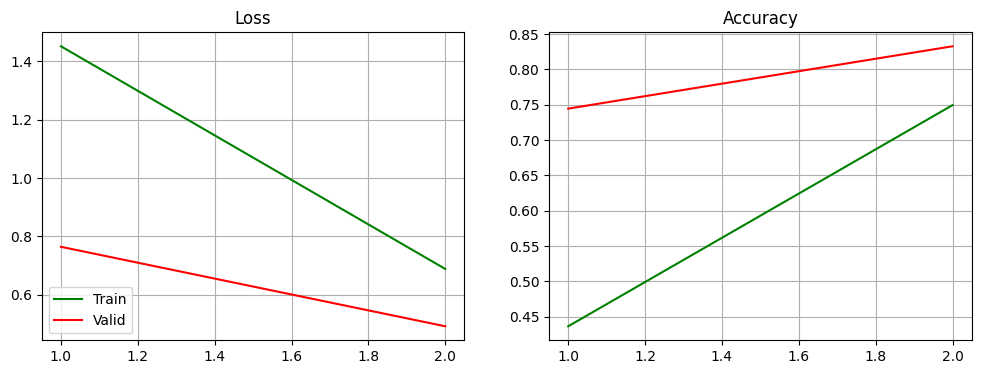

7/7 [==============================] - 1s 107ms/step - loss: 0.6699 - accuracy: 0.6741
Transfer learning: 0.73 minutes

Output saved to the file: /content/drive/MyDrive/Mgr/new_plots/IntelMini_Mobilenet_08_03time.txt
224
224 224
train: 914
    buildings: 130
    forest: 136
    glacier: 117
    mountain: 219
    sea: 156
    street: 156
test: 244
    buildings: 64
    forest: 10
    glacier: 70
    mountain: 100
    sea: 0
    street: 0
valid: 1090
    buildings: 200
    forest: 200
    glacier: 110
    mountain: 180
    sea: 200
    street: 200
Train dataset contains 914 samples (28 steps / epoch)
Valid dataset contains 1090 samples (34 steps / epoch)
Dataset contains 6 classes (['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']).
Found 914 images belonging to 6 classes.
Found 1090 images belonging to 6 classes.
Found 244 images belonging to 6 classes.
Epoch 1/2
28/28 [==============================] - 39s 922ms/step - loss: 1.5938 - accuracy: 0.3866 - val_loss: 0.9533 - 

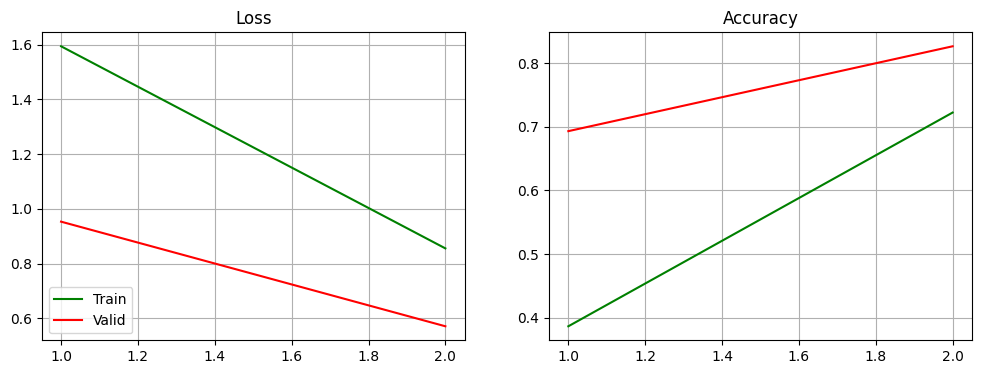

7/7 [==============================] - 1s 136ms/step - loss: 0.7065 - accuracy: 0.7098
Transfer learning: 1.00 minutes

Output saved to the file: /content/drive/MyDrive/Mgr/new_plots/IntelMini_DenseNet169_08_03time.txt
224
224 224
train: 914
    buildings: 130
    forest: 136
    glacier: 117
    mountain: 219
    sea: 156
    street: 156
test: 244
    buildings: 64
    forest: 10
    glacier: 70
    mountain: 100
    sea: 0
    street: 0
valid: 1090
    buildings: 200
    forest: 200
    glacier: 110
    mountain: 180
    sea: 200
    street: 200
Train dataset contains 914 samples (28 steps / epoch)
Valid dataset contains 1090 samples (34 steps / epoch)
Dataset contains 6 classes (['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']).
Found 914 images belonging to 6 classes.
Found 1090 images belonging to 6 classes.
Found 244 images belonging to 6 classes.
Epoch 1/2
28/28 [==============================] - 30s 694ms/step - loss: 1.4574 - accuracy: 0.4626 - val_loss: 0.9232 

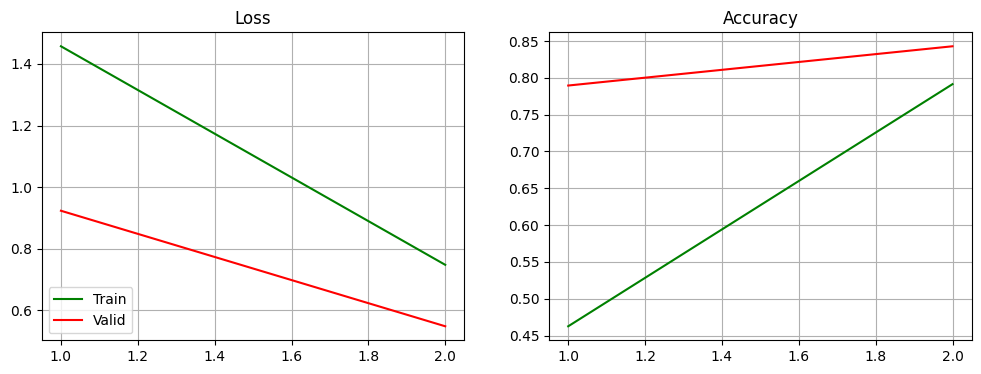

7/7 [==============================] - 1s 92ms/step - loss: 0.7512 - accuracy: 0.6652
Transfer learning: 0.85 minutes

Output saved to the file: /content/drive/MyDrive/Mgr/new_plots/IntelMini_EfficientNetV2B0_08_03time.txt
299
299 299
train: 13498
    air hockey: 112
    ampute football: 112
    archery: 132
    arm wrestling: 99
    axe throwing: 113
    balance beam: 147
    barell racing: 123
    baseball: 174
    basketball: 169
    baton twirling: 108
    bike polo: 110
    billiards: 145
    bmx: 140
    bobsled: 138
    bowling: 120
    boxing: 116
    bull riding: 149
    bungee jumping: 125
    canoe slamon: 164
    cheerleading: 131
    chuckwagon racing: 120
    cricket: 129
    croquet: 134
    curling: 141
    disc golf: 123
    fencing: 135
    field hockey: 157
    figure skating men: 128
    figure skating pairs: 151
    figure skating women: 157
    fly fishing: 134
    football: 191
    formula 1 racing: 190
    frisbee: 131
    gaga: 118
    giant slalom: 150
    gol

KeyboardInterrupt: ignored

In [ ]:
for dataset_name, dataset_path in DATASETS_INFO:
  DATA_PATH = dataset_path
  DATASET_NAME = dataset_name
  transfer_learn()